# Scenarios In Depth

Scenarios are the heart of each simulation. A scenario defines which simulation model to use, optionally points to a source model and has a name. 
It may override model constants and define execution strategies. 

## Understanding The Scenario Definition Format

The latter change constants in different steps of the simulation. See the "strategy simulation" section for details.
You write scenarios in [JSON format](http://www.json.org). The default location to store scenarios is the ``scenarios`` subfolder of your current working directory, you can change this value in the config file. 

We group simulation scenarios by "scenario Managers". One scenario manager encapsulates one simulation model and has a name. Scenarios run this simulation model and modify constants.
One JSON file may contain more than one scenario manager. A simple example with one scenario manager will look like this:

```
{  
    "smSimpleProjectManagement":{
    "source":"simulation_models/sd_simple_project.itmx",
    "model":"simulation_models/sd_simple_project",
    "base_constants": {
          "deadline": 100,
          "effortPerTask": 1,
          "initialOpenTasks": 80,
          "initialStaff": 1
    },
    "base_points": {
        "productivity" : [
        [0,0.4],
        [0.25,0.444],
        [0.5,0.506],
        [0.75,0.594],
        [1,1],
        [1.25,1.119],
        [1.5,1.1625],
        [1.75,1.2125],
        [2,1.2375],
        [2.25,1.245],
        [2.5,1.25]
        ]
    },
    "scenarios": {
      "base": {
      },
      "scenario100": {
        "constants": {
          "initialOpenTasks": 100
        }
      },
      "scenario80": {
        "constants": {
        }
      },
      "scenario120": {
        "constants": {
          "initialOpenTasks": 120
        }
        
      }
    }
 }
}
```
We start with the name of the scenario manager's name under which we all its scenarios.
If you use the same name for a scenario manager in another file, this will be detected and the scenario will be added to the scenario manager. 
The scenario manager stores the model (source file and python file) as well as all scenarios that belong to it. 
The ``model`` parameter contains the (relative) path to the (python) simulation model. If using a relative path, keep in mind that ``BPTK_Py`` looks for the file from your current working directory, i.e. the path of your script or jupyter notebook. 

Then the key ``base_constants`` may follow. It defines the initial state for all models, regardless the state in the model source file. 
Here you can set all constants to a desired state. 
Each scenario stores the same values for the given constants. For example, in this example we set "initialOpenTasks" to 80.
In this case, define ``base_constants`` for the scenario manager in exactly one file, not in multiple. 
In case the base constants stretch over multiple files, ``bptk_py`` attempts to merge them and data loss may occur due to duplicate values for the same constants.
For defining an initial state of the graphical functions we employ ``base_points``. The schema is the same: define the points that are valid for all scenarios unless the ones that override them.

The actual scenarios follow after the ``scenarios`` tag. If you define scenarios for one scenario manager over multiple files, this is O.K. and increases readability for the user.
For each scenario, you have to supply a unique name as well. JSON does not support integer keys. 
The ``constants`` list stores the overrides constants. 
The constants override certain base constants given before. 
The scenario "base" sets "initialOpenTasks" to 100. This value is only valid for this specific scenario. 
The other values such as "deadline" stay the same as the base constants, as there is no overrid. "scenario80" does not override any constants and hence use all base constants. 
You may either define numerical values such as ``0.5`` or use strings to define expressions such as ``"5/10"``which will be evaluated to ``0.5`` by the framework.

You should consider using the ``source`` field in the scenario manager tag. It specifies the (relative) path to the original model file of 3rd party applications. 
For now, the framework supports automatic conversion of .itmx/.stmx files from Stella Architect. 
For each source file, a file monitor will run in background to check for changes in the source model. 
The file monitor will automatically update the python model file whenever a change to the source model is detected. 

## Creating Scenarios During Runtime

It is possible to add scenarios during runtime. For convenience, here is some example code you may use as a template to generate your own scenarios during runtime. If you define multiple scenarios for the same ``scenario_manager``, this is no problem. 

First define the details for the scenario manager and then set up the name of the scenario, the strategy and the constants. The strategy may as well be one of the complex ones as described above. But be careful to define everything correctly. We plan to develop a tool to help you create scenarios a little easier.

In [1]:
import BPTK_Py
bptk = BPTK_Py.bptk()

scenario_manager={
    "smSimpleProject_temp":
    {
        "source": "simulation_models/sd_simple_project.itmx",
        "model": "simulation_models/sd_simple_project"
    }
}
scenario_name = "scenario160"


constants = {
            "deadline" : 160,
            "effortPerTask" : 0.1
        }


scenario_dictionary ={
                 scenario_name:{
                     "constants" : constants
                 } 
             } 
            

bptk.register_scenario_manager(scenario_manager)
bptk.register_scenarios(scenario_manager="smSimpleProject_temp",scenarios=scenario_dictionary)



In [2]:
bptk.list_scenarios(scenario_managers=["smSimpleProject_temp"])


*** smSimpleProject_temp ***
	 scenario160


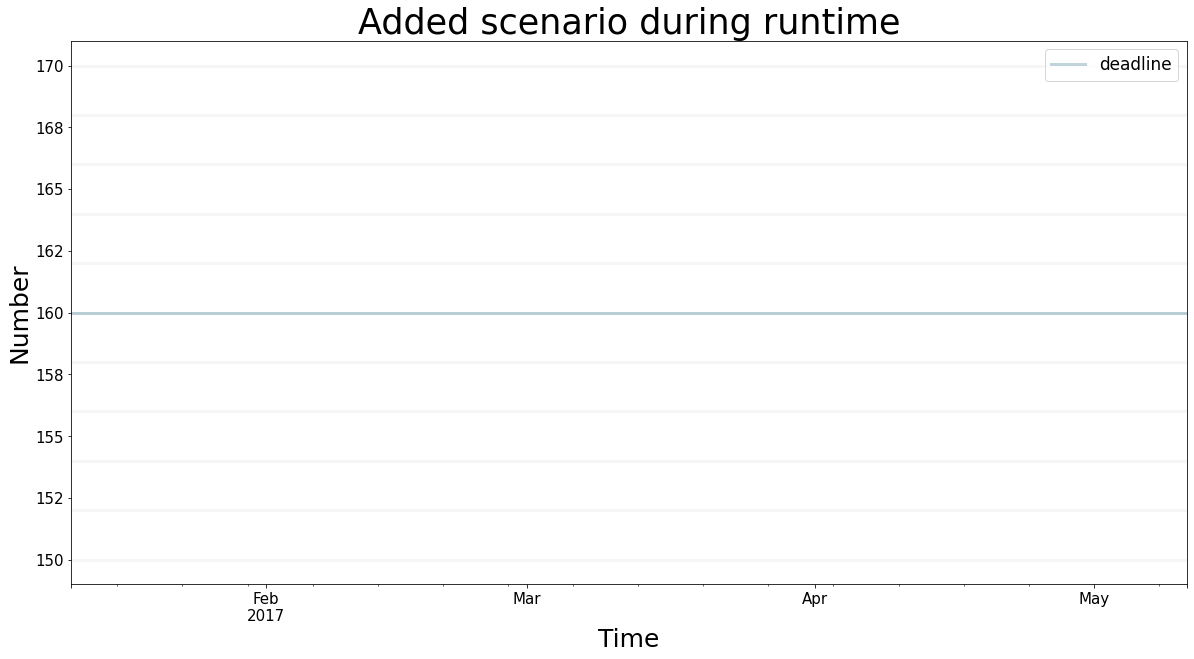

In [4]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProject_temp"],
    scenarios=["scenario160"],
    kind="line",
    equations=["deadline"],
    stacked=False,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
)

You can also register a scenario manger along with some scenarios directly:

In [5]:
scenario_manager={
    "smSimpleProject_another_temp":
    {
        "source": "simulation_models/sd_simple_project.itmx",
        "model": "simulation_models/sd_simple_project",
        "scenarios":{
            "scenario160":{
                "constants":{
                    "deadline" : 160,
                    "effortPerTask" : 0.1
                }
            }
        }
    }
}


bptk.register_scenario_manager(scenario_manager)

In [6]:
bptk.list_scenarios(scenario_managers=["smSimpleProject_temp","smSimpleProject_another_temp"])


*** smSimpleProject_temp ***
	 scenario160

*** smSimpleProject_another_temp ***
	 scenario160


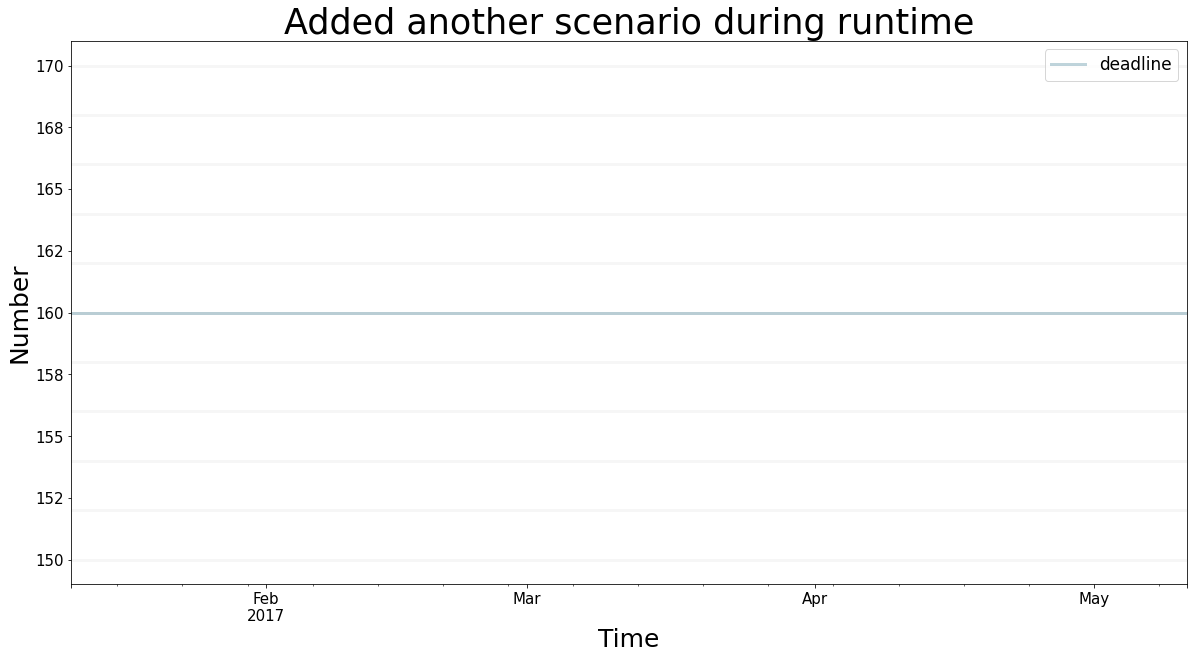

In [8]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProject_another_temp"],
    scenarios=["scenario160"],
    kind="line",
    equations=["deadline"],
    stacked=False,
    freq="D", 
    start_date="1/11/2017",
    title="Added another scenario during runtime",
    x_label="Time",
    y_label="Number",
)

## Resetting Scenarios
After a while of simulating, modifying strategies, constants and generating beautiful plots, you may realize that you want to go back and reset the simulation. For this purpose, you have three methods available:
* ``reset_scenario(scenario_manager, scenario)``: This deletes a specific scenario from memory and reloads it from file. Requires the scenario manager's name and the scenario name.
* ``reset_all_scenarios()``: Reset all scenarios and re-read from file
* ``reset_scenario_cache(scenario_manager, scenario="")``: To optimize the runtime, scenarios cache the results of previous timesteps and previous runs. In some rare cases, this cache may not be flushed upon scenario modification. Hence, this method resets the simulation model's cache.

See the example usages below:


In [10]:
bptk.reset_scenario(scenario_manager="smSimpleProjectManagement",scenario="scenario80")

bptk.reset_all_scenarios()

bptk.reset_scenario_cache("smSimpleProjectManagement","scenario80")
